## Importing libraries

In [320]:
import pandas as pd # to store data efficiently
import numpy as np # to handle numerical operations
from tqdm import tqdm # to visualize loop progressions
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score


## Getting images list with people from COCO dataset

In [295]:
df_names = ['All', 'Top25', 'Top50', 'Top75', 'Side25', 'Side50', 'Side75']

In [296]:
all_predictions_df = pd.read_csv('./data/yolo_prediction/All.csv')
all_anns_df = pd.read_csv('./data/coco_diff/All.csv')
single_anns_df = pd.read_csv('./data/coco_diff/single_anns/person_anns.csv')

<Axes: >

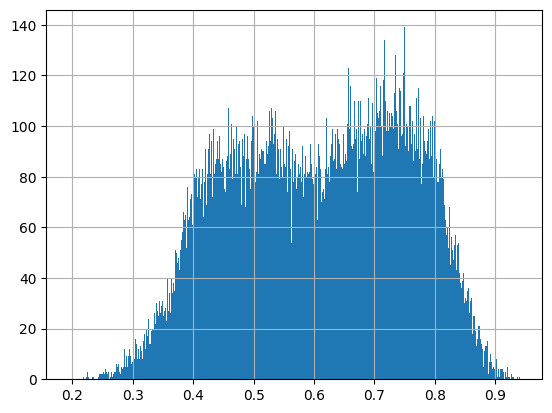

In [298]:
all_anns_df['total_dif'].hist(bins=1000)

Looking at the distribution, I can suggest three difficulty labels:
- Easy: images whose total_diff value is minor than 0.5
- Medium: images whose total_diff value is between 0.5 and 0.7
- Hard: images whose total_diff value is between 0.7 and 0.8
- Very Hard: images whose total_diff value is greater than 0.8

In [299]:
data = all_anns_df['total_dif'].sort_values()
easy = 0.5
medium = 0.7
hard = 0.8
easy_percent = float((data < easy).mean() * 100)
medium_percent = float(((data >= easy) & (data < medium)).mean() * 100)
hard_percent = float(((data >= medium) & (data < hard)).mean() * 100)
very_hard_percent = float((data >= hard).mean() * 100)

In [300]:
print(easy_percent)
print(medium_percent)
print(hard_percent)
print(very_hard_percent)

27.413684764702882
40.56688687736698
23.123821816143877
8.895606541786254


Here it's possible to see the percentiles the given value belong to. With this labeling we will have approximately the 27% of the data being considered as _easy_, 41% of the data considered as _medium_, 23% of the data considered as _hard_,  and 9% of the data being considered as _very hard_. 

In [301]:
def apply_total_dif_labeling(df, col):
    conditions = [
        (df[f'{col}'] < 0.4),
        (df[f'{col}'] > 0.85),
        (df[f'{col}'] > 0.6) & (df[f'{col}'] <= 0.85),
        (df[f'{col}'] >= 0.4) & (df[f'{col}'] <= 0.6)
    ]
    choices = ['easy', 'very hard', 'hard', 'medium']
    df['label'] = np.select(conditions, choices, default='unknown')
    return df

In [302]:
all_anns_df = apply_total_dif_labeling(all_anns_df, 'total_dif')

## Precision

In [303]:
def detect_on_threshold(df, threshold):
    df['detected'] = df['Confidence'].apply(lambda x: 1 if x>=threshold else 0)

In [304]:
detect_on_threshold(all_predictions_df, 0.5)

## Grouping

In [305]:
grouped_predictions_df = all_predictions_df.groupby('Img_ID').agg(
    {
        'Confidence': 'mean',
        'detected': 'sum',
    }
)

In [306]:
df_out = pd.merge(all_anns_df, grouped_predictions_df, how='inner', left_on='Img', right_on='Img_ID')
df_out.set_index('Img', inplace=True)
df_out = df_out[['Confidence', 'label', 'detected', 'num_people']]

In [310]:
def adding_precision_feature(df):
    df['accuracy'] = df['detected'] / df['num_people']
    df['true_pos'] = np.minimum(df['detected'], df['num_people'])
    df['false_pos'] = np.maximum(df['detected'] - df['num_people'], 0)
    df['false_neg'] = np.maximum(df['num_people'] - df['detected'], 0)

In [323]:
def adding_metrics_features(df):
    df['mae'] = np.abs(df['num_people']-df['detected'])
    df['mse'] = (df['num_people']-df['detected'])**2
    df['correct'] =(df['detected'] == df['num_people']).astype(int)
    df['precision'] = (df['true_pos']/(df['true_pos']+df['false_pos']))
    df['recall'] = (df['true_pos']/(df['true_pos']+df['false_neg']))
    df['f1-score'] = 2*((df['precision']*df['recall'])/(df['precision']+df['recall']))
    
    df.fillna({'precision': 0, 'recall': 0, 'f1-score': 0}, inplace=True)

In [324]:
adding_precision_feature(df_out)
adding_metrics_features(df_out)

In [325]:
df_out

,Confidence,label,detected,num_people,accuracy,true_pos,false_pos,false_neg,mae,mse,correct,precision,recall,f1-score
Img,,,,,,,,,,,,,,
326,0.866764,medium,1,1,1.00,1,0,0,0,0,1,1.0,1.00,1.000000
1149,0.607025,hard,9,12,0.75,9,0,3,3,9,0,1.0,0.75,0.857143
1200,0.739418,hard,3,3,1.00,3,0,0,0,0,1,1.0,1.00,1.000000
1319,0.431452,medium,0,1,0.00,0,0,1,1,1,0,0.0,0.00,0.000000
1900,0.000000,hard,0,1,0.00,0,0,1,1,1,0,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579891,0.909920,medium,1,1,1.00,1,0,0,0,0,1,1.0,1.00,1.000000
580781,0.841013,medium,1,1,1.00,1,0,0,0,0,1,1.0,1.00,1.000000
581183,0.605279,hard,3,12,0.25,3,0,9,9,81,0,1.0,0.25,0.400000


### Plotting

In [331]:
def plot_grouped_boxplot(df, feature, name=None):
    plt.figure(figsize=(8, 6))
    custom_palette = {
        'easy': 'yellow',
        'medium': 'orange',
        'hard': 'red',
        'very hard': 'purple'
    }

    label_order = ['easy', 'medium', 'hard', 'very hard']


    sns.boxplot(data=df, x='label', y=feature, hue='label', palette=custom_palette, dodge=False, legend=False, order=label_order)
    if name:
        plt.title(f"Boxplot of {feature} by Label - {name}")
    else:
        plt.title(f"Boxplot of {feature} by Label")
    plt.xlabel("Label")
    plt.ylabel(f"{feature}")

    plt.show()

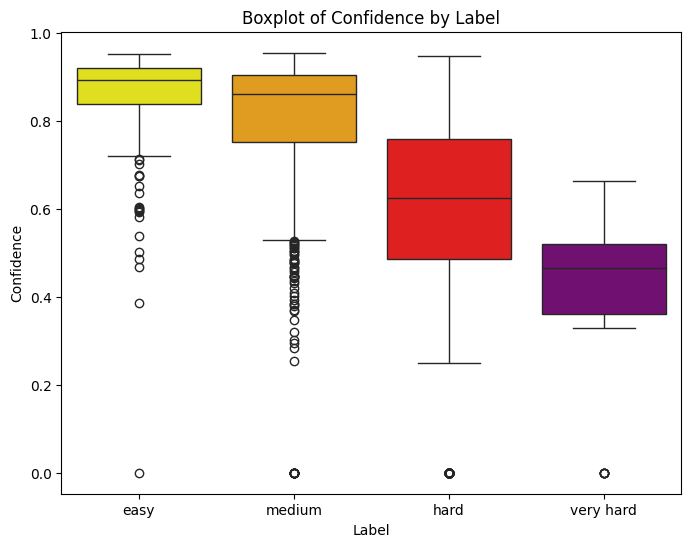

In [327]:
plot_grouped_boxplot(df_out, 'Confidence')

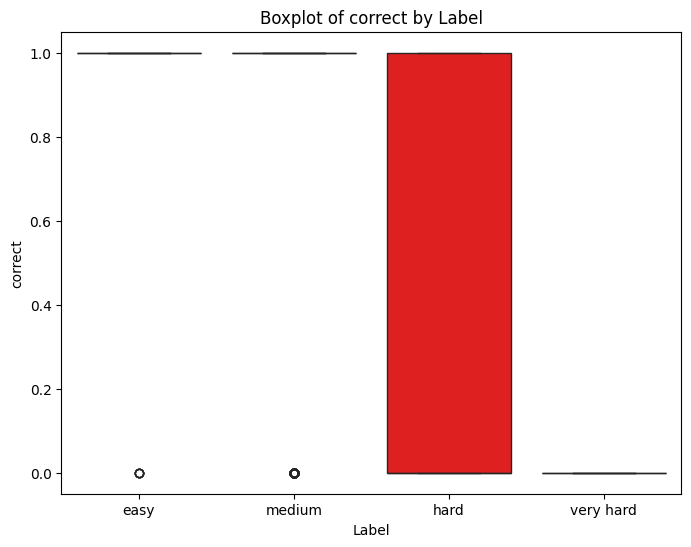

In [329]:
plot_grouped_boxplot(df_out, 'correct')

In [337]:
def group_df_and_agg_metrics(df):
    label_grouped = df_out.groupby('label').agg(
        {
            'mae': 'mean',
            'mse': 'mean',
            'correct': 'mean'
        }
    )

    label_grouped['rmse'] = np.sqrt(label_grouped['mse'])
    return label_grouped

### Replicate for all other dataframes

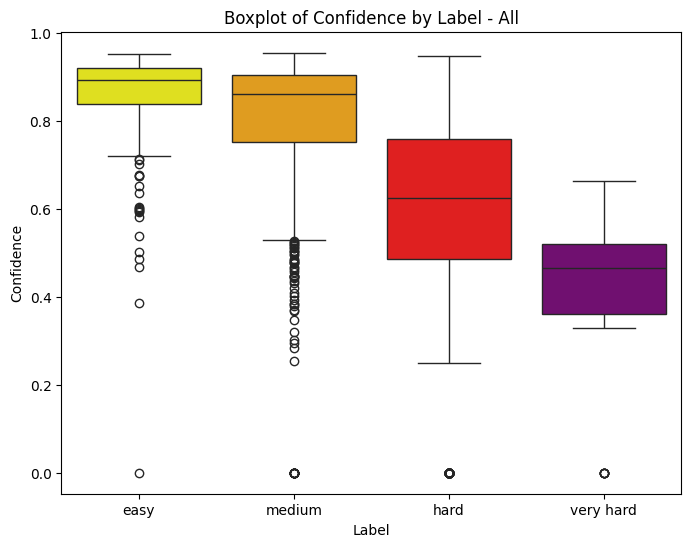

                mae        mse   correct      rmse
label                                             
easy       0.033113   0.033113  0.966887  0.181969
hard       2.103483  10.210945  0.279602  3.195457
medium     0.167079   0.231436  0.857673  0.481078
very hard  5.567568  39.729730  0.000000  6.303152


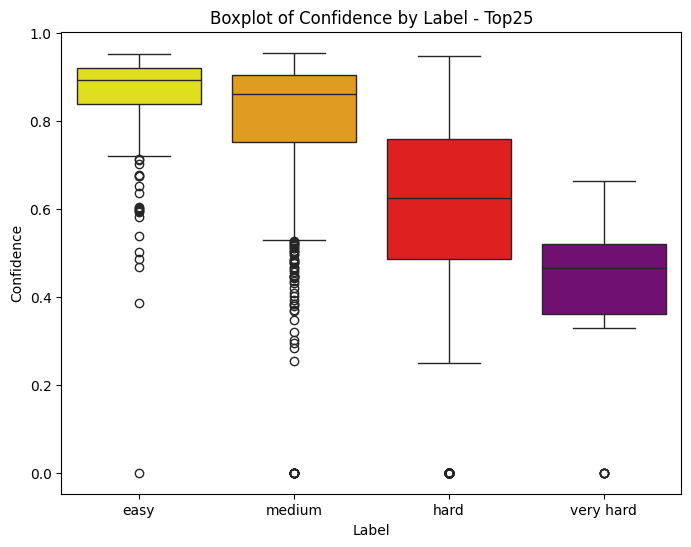

                mae        mse   correct      rmse
label                                             
easy       0.033113   0.033113  0.966887  0.181969
hard       2.103483  10.210945  0.279602  3.195457
medium     0.167079   0.231436  0.857673  0.481078
very hard  5.567568  39.729730  0.000000  6.303152


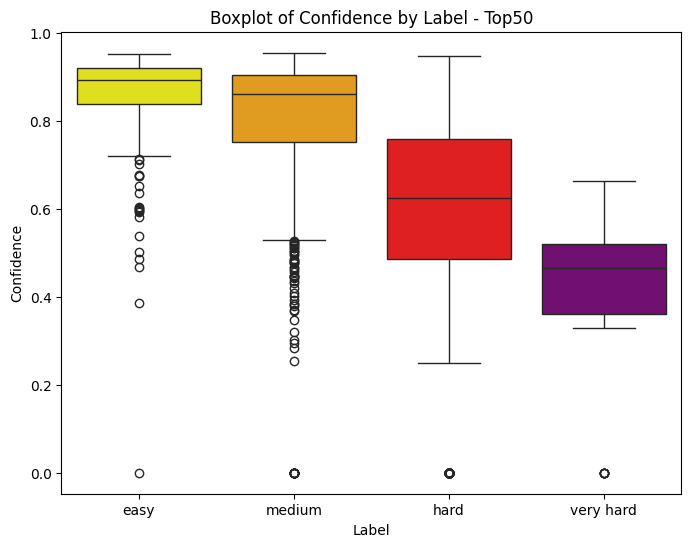

                mae        mse   correct      rmse
label                                             
easy       0.033113   0.033113  0.966887  0.181969
hard       2.103483  10.210945  0.279602  3.195457
medium     0.167079   0.231436  0.857673  0.481078
very hard  5.567568  39.729730  0.000000  6.303152


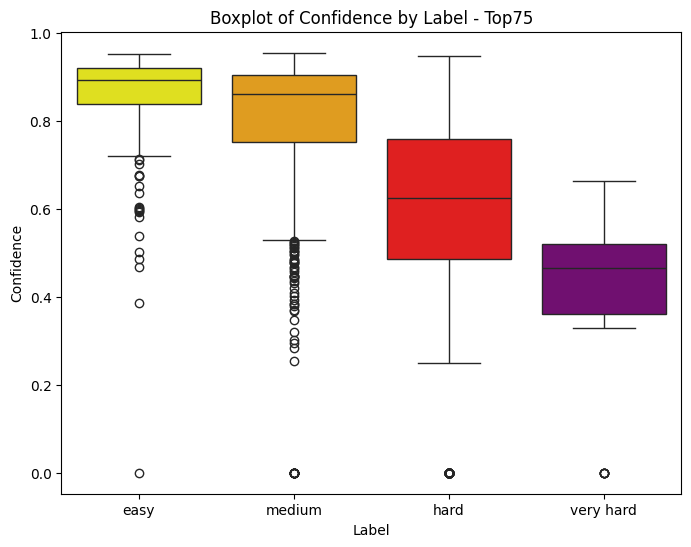

                mae        mse   correct      rmse
label                                             
easy       0.033113   0.033113  0.966887  0.181969
hard       2.103483  10.210945  0.279602  3.195457
medium     0.167079   0.231436  0.857673  0.481078
very hard  5.567568  39.729730  0.000000  6.303152


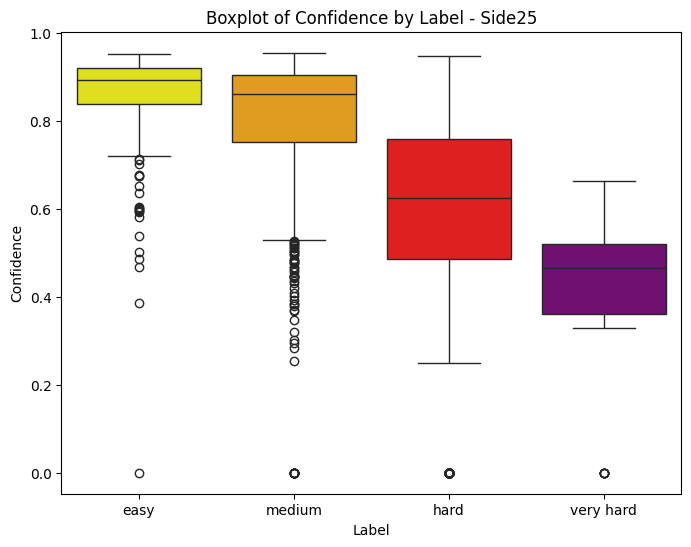

                mae        mse   correct      rmse
label                                             
easy       0.033113   0.033113  0.966887  0.181969
hard       2.103483  10.210945  0.279602  3.195457
medium     0.167079   0.231436  0.857673  0.481078
very hard  5.567568  39.729730  0.000000  6.303152


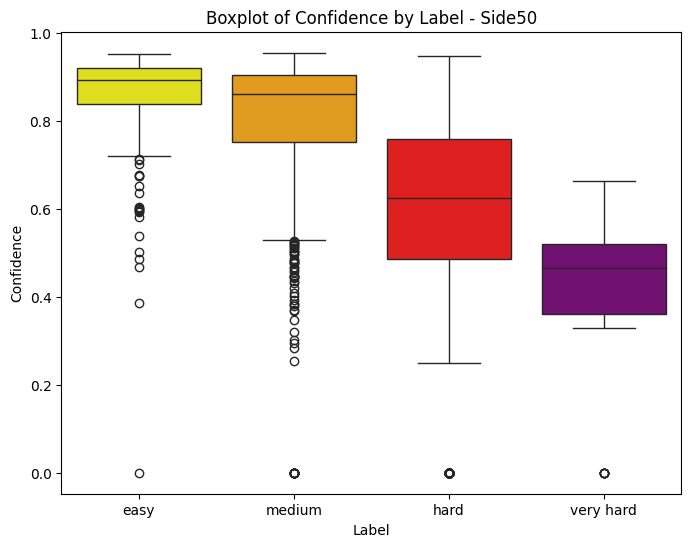

                mae        mse   correct      rmse
label                                             
easy       0.033113   0.033113  0.966887  0.181969
hard       2.103483  10.210945  0.279602  3.195457
medium     0.167079   0.231436  0.857673  0.481078
very hard  5.567568  39.729730  0.000000  6.303152


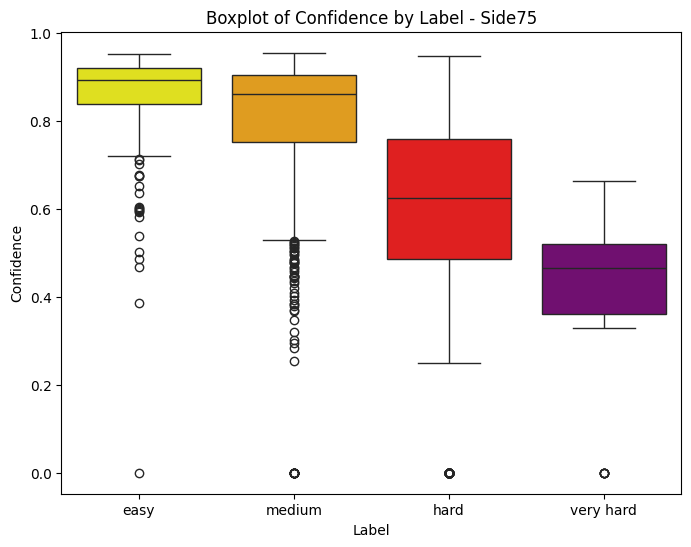

                mae        mse   correct      rmse
label                                             
easy       0.033113   0.033113  0.966887  0.181969
hard       2.103483  10.210945  0.279602  3.195457
medium     0.167079   0.231436  0.857673  0.481078
very hard  5.567568  39.729730  0.000000  6.303152


In [339]:
df_list = []
for name in df_names:
    pred_df = pd.read_csv(f'./data/yolo_prediction/{name}.csv')
    anns_df = pd.read_csv(f'./data/coco_diff/{name}.csv')
    anns_df = apply_total_dif_labeling(anns_df, 'total_dif')
    detect_on_threshold(pred_df, 0.5)
    df = pd.merge(anns_df, pred_df, how='inner', left_on='Img', right_on='Img_ID')
    df.set_index('Img', inplace=True)
    df = df[['Confidence', 'label', 'detected', 'num_people']]
    adding_precision_feature(df)
    adding_metrics_features(df)
    df_list.append(df)
    plot_grouped_boxplot(df_out, 'Confidence', name=name)
    print(group_df_and_agg_metrics(df))